In [1]:
import numpy as np
from scipy.special import erf


class AsianOptionMC_MC(object):
    """ Class for Asian options pricing using control variate
    S0 : float : initial stock/index level
    strike : float : strike price
    T : float : time to maturity (in year fractions)
    M : int : grid or granularity for time (in number of total points)
    r : float : constant risk-free short rate
    div :    float : dividend yield
    sigma :  float : volatility factor in diffusion term 
    """

    def __init__(self, option_type, S0, strike, T, M, r, div, sigma, simulations):
        try:
            self.option_type = option_type
            assert isinstance(option_type, str)
            self.S0 = float(S0)
            self.strike = float(strike)
            self.T = float(T)
            self.M = int(M)
            self.r = float(r)
            self.div = float(div)
            self.sigma = float(sigma)
            self.simulations = int(simulations)
        except ValueError:
            print('Error passing Options parameters')

        if option_type != 'call' and option_type != 'put':
            raise ValueError("Error: option type not valid. Enter 'call' or 'put'")
        if S0 < 0 or strike < 0 or T <= 0 or r < 0 or div < 0 or sigma < 0:
            raise ValueError('Error: Negative inputs not allowed')

        self.time_unit = self.T / float(self.M)
        self.discount = np.exp(- self.r * self.T)

    @property
    def GeometricAsianOption(self):
        sigsqT = ((self.sigma ** 2 * self.T * (self.M + 1) * (2 * self.M + 1))
                  / (6 * self.M * self.M))
        muT = (0.5 * sigsqT + (self.r - 0.5 * self.sigma ** 2)
               * self.T * (self.M + 1) / (2 * self.M))
        d1 = ((np.log(self.S0 / self.strike) + (muT + 0.5 * sigsqT))
              / np.sqrt(sigsqT))
        d2 = d1 - np.sqrt(sigsqT)
        N1 = 0.5 * (1 + erf(d1 / np.sqrt(2)))
        N2 = 0.5 * (1 + erf(d2 / np.sqrt(2)))
        geometric_value = self.discount * (self.S0 * np.exp(muT) * N1 - self.strike * N2)
        return geometric_value

    @property
    def price_path(self, seed = 100):
        np.random.seed(seed)
        price_path = (self.S0 *
                      np.cumprod (np.exp ((self.r - 0.5 * self.sigma ** 2) * self.time_unit +
                                    self.sigma * np.sqrt(self.time_unit) 
                                          * np.random.randn(self.M,self.simulations)), 1))
        plt.figure(figsize=(20, 12))
        plt.title('100 Simulated Stocks Paths for Asian Options',fontweight="bold", pad=20)
        plt.xlabel('Steps')
        plt.ylabel('Price')
        plt.plot(price_path[:, :5]);
        
        plt.figure(figsize=(10,6))
        plt.hist(price_path[-1], bins=45)
        plt.title('Histogram of Final Value of the Stock',fontweight="bold", pad=20);
        plt.axvline(price_path[-1].mean(), c='b');
        # plt.savefig('histogram.png', facecolor='None')
        
        S_sim = np.zeros(self.simulations)
        for x in range(0,self.simulations):
            S_sim[x] = price_path[-1][0:x+1].mean()
        plt.figure(figsize=(10, 6))
        plt.title('Convergence Into Mathematical Value',fontweight="bold", pad=20)
        plt.xlabel('Iterations')
        plt.ylabel('Final Price')
        plt.plot(S_sim);
        # plt.savefig('convergence.png', facecolor='None')
        return price_path

    @property
    def MCPayoff(self): #asian payoff = (1/T\int_0^T S_tdt - K)^+ #lookback payoff = S_T - Min(S_t, t<=T) 
        if self.option_type == 'call':
            MCpayoff =  np.maximum((self.discount*np.mean(self.price_path,1))-self.strike, 0) 
        else:
            MCpayoff = np.maximum(self.strike-(self.discount*np.mean(self.price_path,1)), 0)
        return MCpayoff
    
    @property 
    def value(self):
        MCvalue = np.mean(self.MCPayoff)
        MCValue_std = np.std(self.MCPayoff)
        upper_bound = MCvalue + 1.96 * MCValue_std/np.sqrt(self.simulations)
        lower_bound = MCvalue - 1.96 * MCValue_std/np.sqrt(self.simulations)
        return MCvalue, lower_bound, upper_bound


Asian Call values
 MC value           Lower Bound         Upper Bound
(3.329538369176146, 2.4428012813222653, 4.216275457030027)


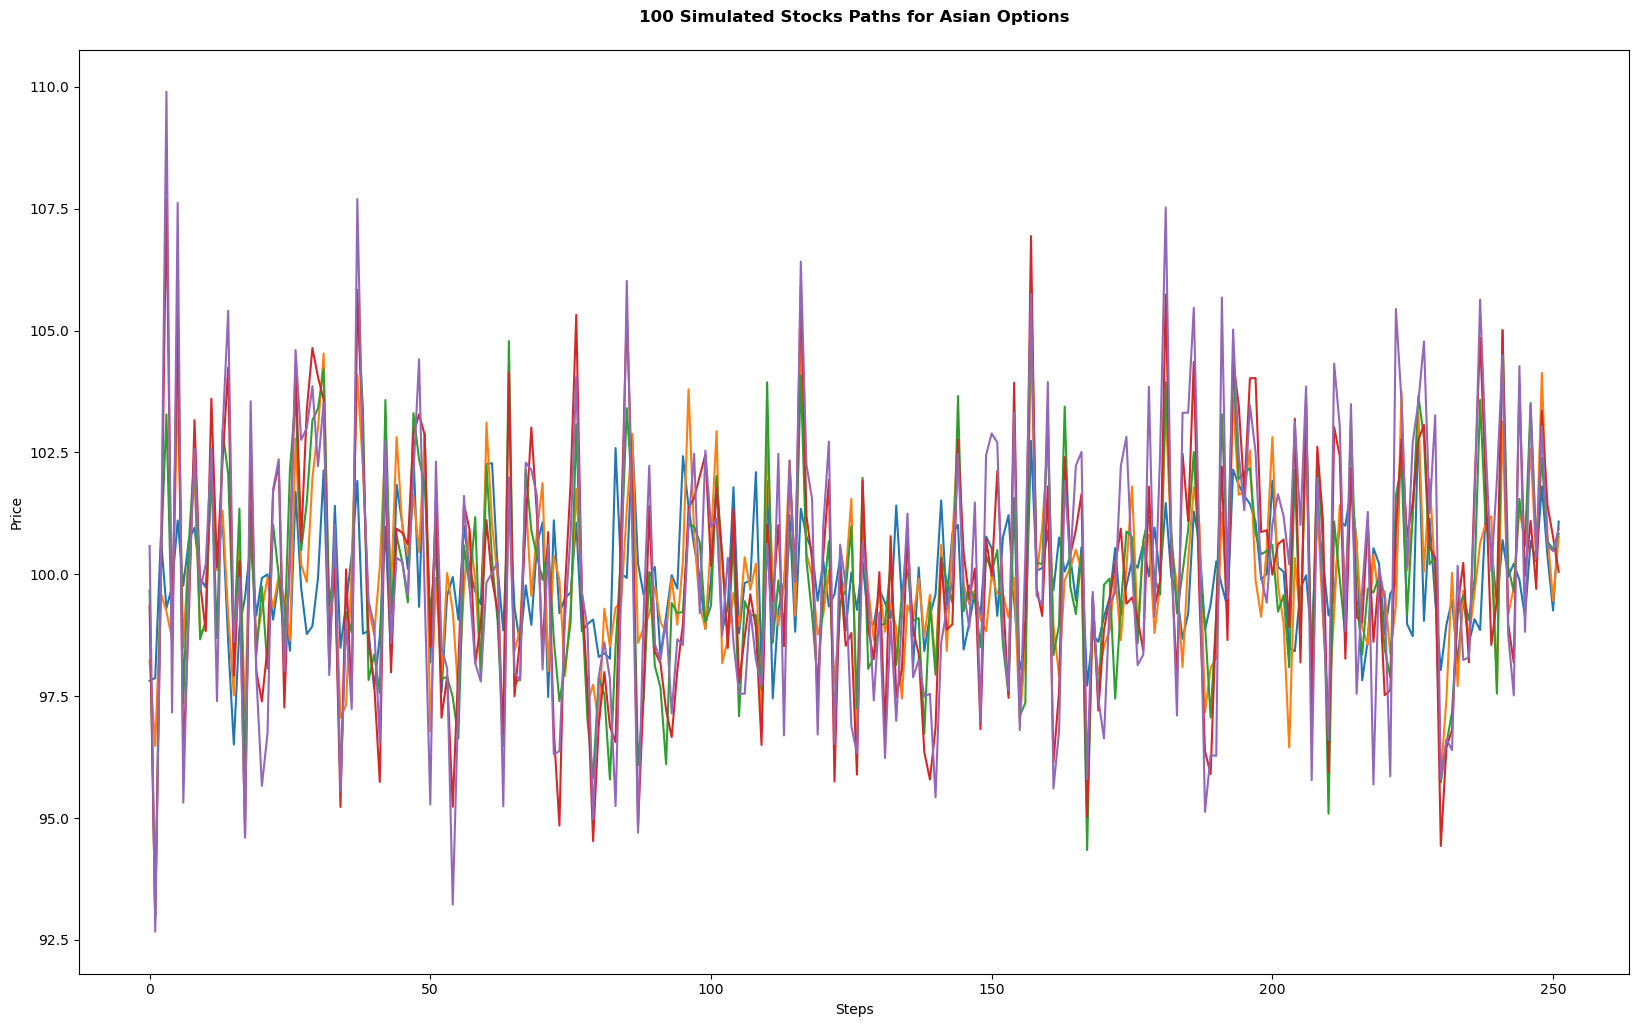

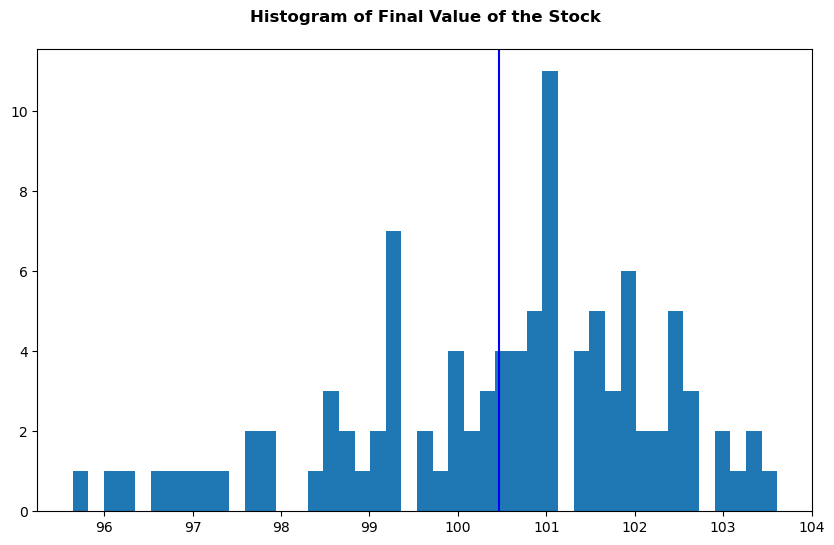

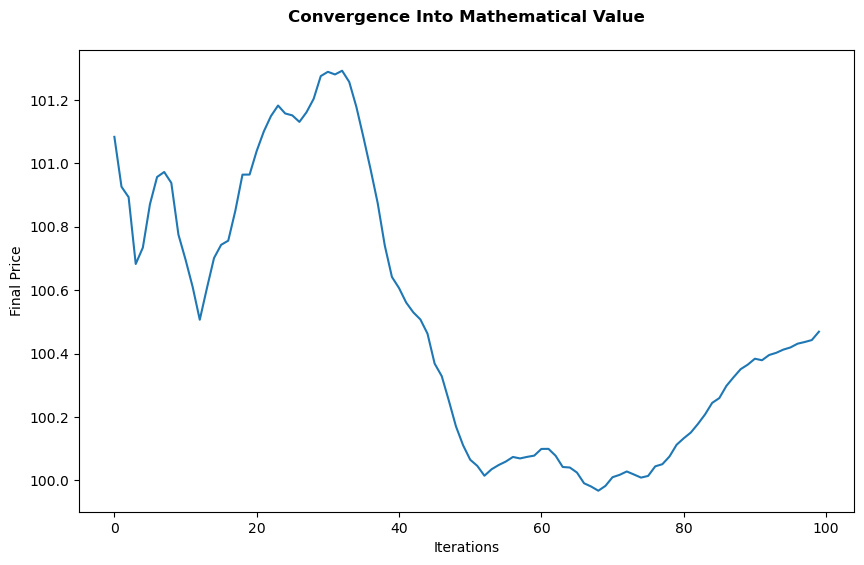

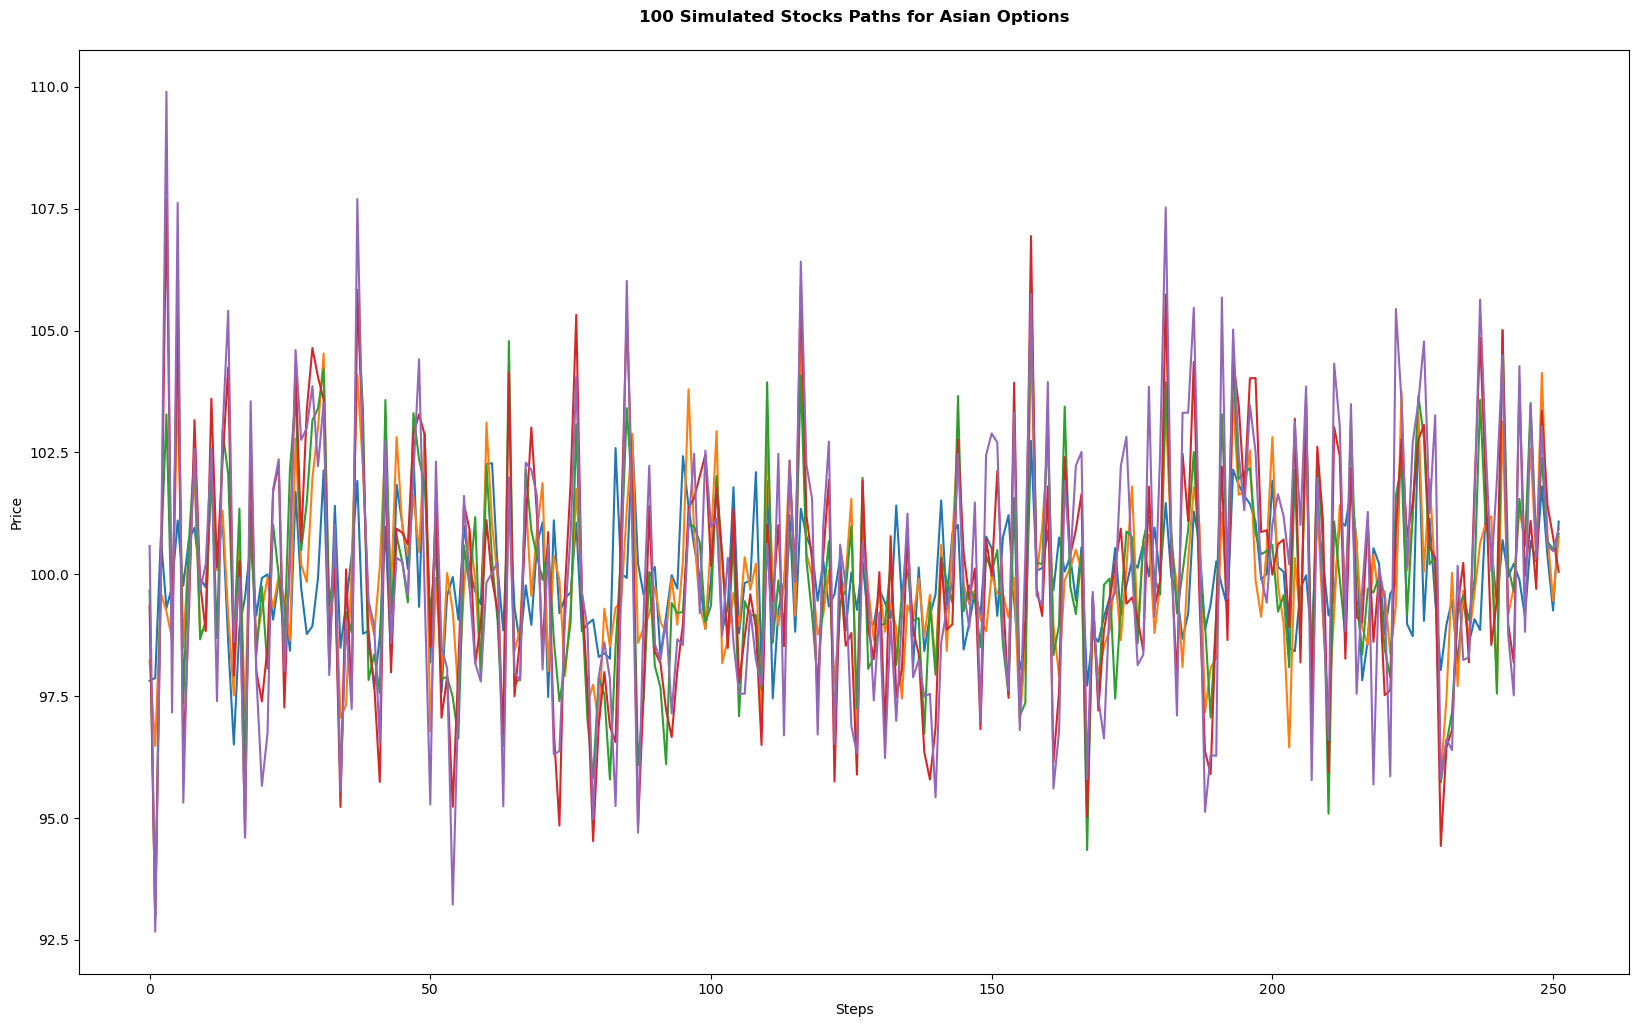

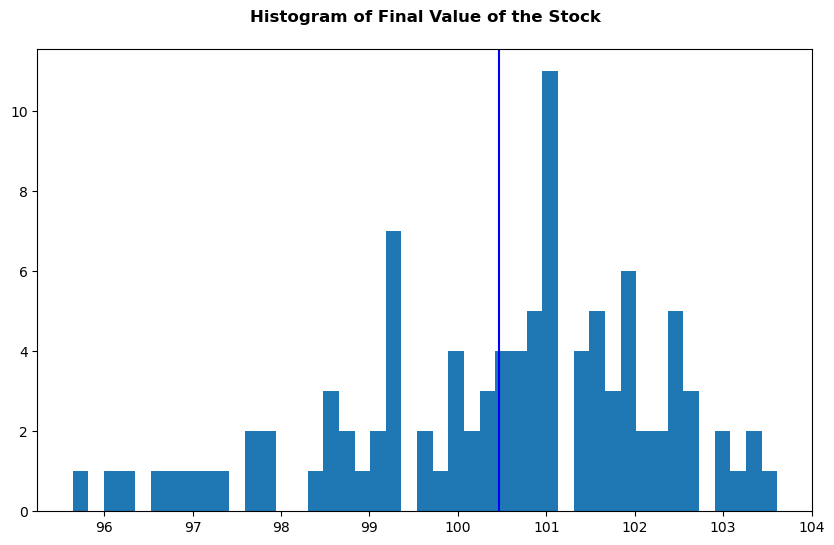

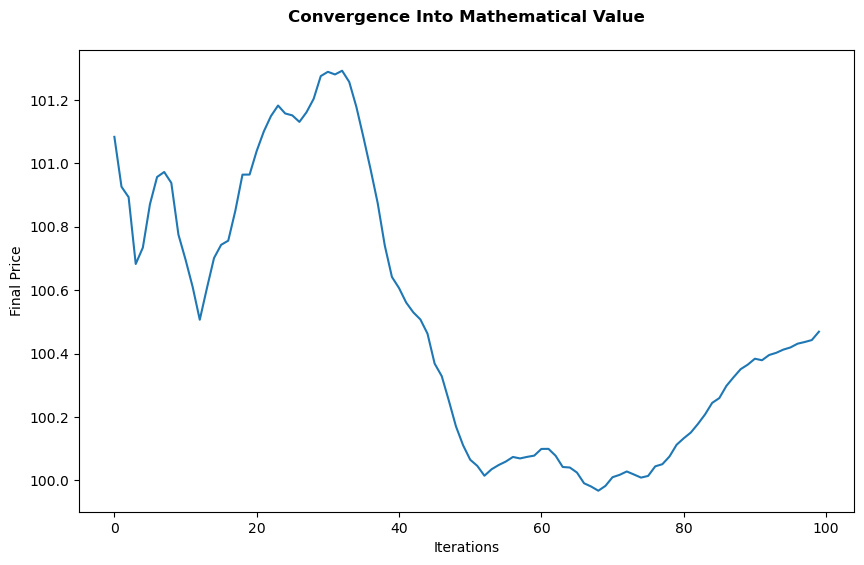

In [5]:
import matplotlib.pyplot as plt
AsianCall = AsianOptionMC_MC('call', 100., 99., 1., 252, .01, 0, .20, 100)
print("Asian Call values")
print(" MC value           Lower Bound         Upper Bound")
print(AsianCall.value)